In [11]:
import numpy as np
from numpy import array
%matplotlib inline
import matplotlib.pyplot as plt
import random
import pickle

import scipy

import skimage.transform as sit
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.svm import SVC

In [12]:
import pulse2percept as p2p
import visual
import importlib

In [13]:
imgw = np.load("imgw.npy") #800x800
imgwlarge = np.load("imgwlarge.npy") #1520x520
img_original = io.imread("Landolt5.png")
img_og = io.imread("Landolt2.png")

[100.27 102.93 ... 353.75 353.74] (600,)
353.7379057794138 311.4119854519293


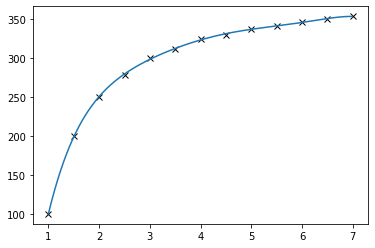

In [14]:
data = [[1,100],[1.5,200],[2,250],[2.5,279],[3,300],[3.5,312],[4,325],[4.5,330],[5,337],[5.5,342],[6,347],[6.5,350],[7,354]]
x, y = zip(*data)
plt.plot(x, y, 'kx')

#stacked_x = np.array([x,x+1,x-1])
#logistic function
coeffs = np.polyfit(x,y,6)#mpf(stacked_x, y, deg) (for multivariate data)
x2 = np.arange(min(x), max(x), .01) #use more points for a smoother plot
y2 = np.polyval(coeffs, x2) #Evaluates the polynomial for each x2 value
print(y2, y2.shape)
print(y2[599], y2[245]) #last value in array = 7x compression
plt.plot(x2, y2)

In [15]:
B = []
for i in range(0,9):
    for j in range(0,9):
        for k in range(0,9):
            B.append(str(i) + str(j) + str(k))
print(B)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '010', '011', '012', '013', '014', '015', '016', '017', '018', '020', '021', '022', '023', '024', '025', '026', '027', '028', '030', '031', '032', '033', '034', '035', '036', '037', '038', '040', '041', '042', '043', '044', '045', '046', '047', '048', '050', '051', '052', '053', '054', '055', '056', '057', '058', '060', '061', '062', '063', '064', '065', '066', '067', '068', '070', '071', '072', '073', '074', '075', '076', '077', '078', '080', '081', '082', '083', '084', '085', '086', '087', '088', '100', '101', '102', '103', '104', '105', '106', '107', '108', '110', '111', '112', '113', '114', '115', '116', '117', '118', '120', '121', '122', '123', '124', '125', '126', '127', '128', '130', '131', '132', '133', '134', '135', '136', '137', '138', '140', '141', '142', '143', '144', '145', '146', '147', '148', '150', '151', '152', '153', '154', '155', '156', '157', '158', '160', '161', '162', '163', '164', '165', '166', '167'

In [16]:
#amount of noise
noises = [.0625*i for i in range(0, 9)]
print("noises: ", noises)
#size of stimulus (larger compression = smaller stimulus)
compressions = [.5*i for i in range(2,11)]
print("compressions: ", compressions)
#% translations (1 allows C-ring to move to edge of image, .5 = halfway, etc.)
scalings = [.125*i for i in range(0,9)] #[::-1] 0 is easier
print("scalings: ", scalings)

iterations = 1 #make it 4 when filling the results. 256 images / check is good enough
testsize = 0.25

tempfeatures = []
theta = 45
for l in range(0, int(np.rint(360 / theta))):
    for m in range(0, 8*iterations): 
        tempfeatures.append(l * theta)

print("features: ", tempfeatures)

noises:  [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5]
compressions:  [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
scalings:  [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
features:  [0, 0, 0, 0, 0, 0, 0, 0, 45, 45, 45, 45, 45, 45, 45, 45, 90, 90, 90, 90, 90, 90, 90, 90, 135, 135, 135, 135, 135, 135, 135, 135, 180, 180, 180, 180, 180, 180, 180, 180, 225, 225, 225, 225, 225, 225, 225, 225, 270, 270, 270, 270, 270, 270, 270, 270, 315, 315, 315, 315, 315, 315, 315, 315]


In [17]:
def image_set(file, theta=45, noise=0, compress=1.0, scaling=1, dim=256, itr=1):
    shift = int(np.rint((y2[int((compress - 1) * 100)]) * scaling)) #w/o 800/800
    start = int((1520 - 800) / 2)  #1520 - 800 / 2
    stop = int(start + 800) #start + 800

    #initialize list
    A = np.empty([8*int(np.rint(360/theta))*itr, dim*dim])
    print(A.shape)
    #unnecessary, could just index A
    lst = [0]*8
    
    for i in range(0, int(np.rint(360 / theta))):
        new_img2 = img_og.copy()[start:stop, start:stop]
        if (compress != 1):
            new_img2 = visual.compressx(new_img2, compress)[0:800, 0:800]

        #deleted the old code and can't remember how to do it elegantly but this works
        new_img2 = visual.rotateclean(new_img2, theta * i)
        new_img = img_og.copy()
        new_img[start:stop, start:stop] = new_img2
        new_img = new_img[:,:,0]
        
        for j in range(0, itr):
            a = start + random.randint(0, shift) 
            lst[0] = resize(new_img[a:a+800, start:stop], (dim, dim)).flatten()
            
            a = start - random.randint(0, shift) #start - 
            lst[1] = resize(new_img[a:a+800, start:stop], (dim, dim)).flatten()
            
            a = start + random.randint(0, shift) #start + 
            lst[2] = resize(new_img[start:stop, a:a+800], (dim, dim)).flatten()
            
            a = start - random.randint(0, shift)
            lst[3] = resize(new_img[start:stop, a:a+800], (dim, dim)).flatten()
            
            a = start + random.randint(0, shift)
            b = start + random.randint(0, shift)
            lst[4] = resize(new_img[a:a+800, b:b+800], (dim, dim)).flatten()
            
            a = start - random.randint(0, shift)
            b = start + random.randint(0, shift)
            lst[5] = resize(new_img[a:a+800, b:b+800], (dim, dim)).flatten()
            
            a = start + random.randint(0, shift)
            b = start - random.randint(0, shift)
            lst[6] = resize(new_img[a:a+800, b:b+800], (dim, dim)).flatten()
            
            a = start - random.randint(0, shift)
            b = start - random.randint(0, shift)
            lst[7] = resize(new_img[a:a+800, b:b+800], (dim, dim)).flatten()
            
            print(i, j)
            A[i*(8*itr) + j*8:i*(8*itr) + (j+1)*8] = lst
    
    A[A<0.5] = 0
    A[A>=0.5] = 1

    #double check noise later
    if (noise != 0):
        visual.groupswitch(A, noise, dim)
        
    return A

In [42]:
def cross_validate(X, y=tempfeatures, splits=5):
    skf = StratifiedKFold(splits)
    clf = LinearDiscriminantAnalysis(solver='lsqr')

    results = []
    accuracy = 0
    tempf = np.array(y)
    print(tempf)

    for train, test in skf.split(X, tempf):
        xt, xv, yt, yv = X[train], X[test], tempf[train], tempf[test]
        print(X[train].shape, X[test].shape, tempf[train].shape, tempf[test].shape)
        clf.fit(xt, yt)
        yhat = clf.predict(xv)

        if ((yhat == yv).all() == True):
            results.append(1)
        else:
            results.append(0)

    accuracy = sum(results) / np.shape(results)[0]
    return accuracy

In [27]:
subs = image_set(B[0], noise=noises[0], compress=compressions[0], scaling=scalings[0], dim=256, itr=iterations)

(64, 65536)
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0


In [ ]:
%%time
#just testing cross-validation on one dataset with all the supposedly easiest parameters - no noise, no compression, no scaling.
#only one copy / image, iterations = 1 right now just so there's not a bunch of images. 256 images total with itr = 1

#print(cross_validate(subs))
print(cross_validate(test_set, features, 2)) #minimum of 4 / class, trying a base case


[  0   0 ... 270 270]
(8, 65536) (8, 65536) (8,) (8,)


In [59]:
#building up a smaller image set to try to figure out why cross validation takes so long.
repeats = 4
shift = int(np.rint((y2[0]) * 1)) #w/o 800/800
start = int((1520 - 800) / 2)  #1520 - 800 / 2
stop = int(start + 800) #start + 800

#initialize list
test_set = np.empty([4*repeats, 256*256])
print(test_set.shape)
#unnecessary, could just index A
lst = [0]*repeats

for i in range(0, 4):
    new_img2 = img_og.copy()[start:stop, start:stop]

    new_img2 = visual.rotateclean(new_img2, 90 * i)
    new_img = img_og.copy()
    new_img[start:stop, start:stop] = new_img2
    new_img = new_img[:,:,0]

    lst[0] = resize(new_img[start:stop, start:stop], (256, 256)).flatten()
    #(avoiding error where # images <= # unique features) 
    lst[1] = resize(new_img[start+1:stop+1, start:stop], (256, 256)).flatten() #resize(imgwlarge[:,:,0], (256, 256)).flatten()
    lst[2] = resize(new_img[start-1:stop-1, start:stop], (256, 256)).flatten()
    lst[3] = resize(new_img[start:stop, start+1:stop+1], (256, 256)).flatten()
    #print(np.amax(lst[0]), np.amax(lst[1]), np.amin(lst[0]), np.amin(lst[1]))
    test_set[i*repeats:i*repeats + repeats] = lst
    print(i*repeats, i*repeats + repeats)
    
test_set[test_set<0.5] = 0
test_set[test_set>=0.5] = 1

features = [0] * (4 * repeats)
for l in range(0, 4):
    for m in range(0, repeats): 
        print(l*repeats + m)
        features[l*repeats + m] = (l * 90)
print(features)


(16, 65536)
0 4
4 8
8 12
12 16
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[0, 0, 0, 0, 90, 90, 90, 90, 180, 180, 180, 180, 270, 270, 270, 270]


<Figure size 432x288 with 0 Axes>

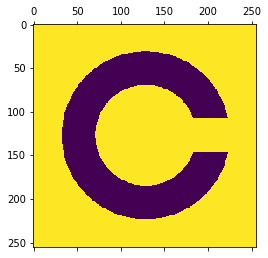

<Figure size 432x288 with 0 Axes>

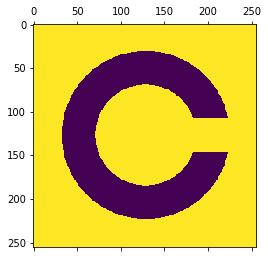

<Figure size 432x288 with 0 Axes>

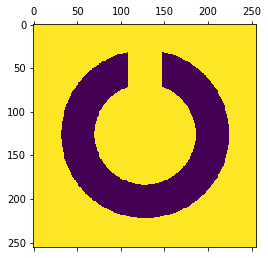

<Figure size 432x288 with 0 Axes>

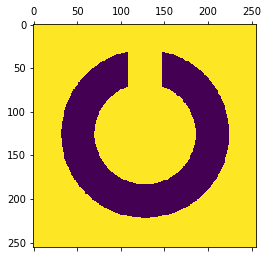

<Figure size 432x288 with 0 Axes>

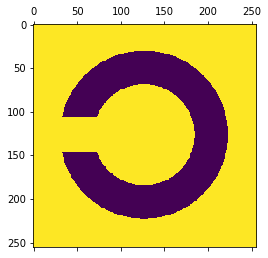

<Figure size 432x288 with 0 Axes>

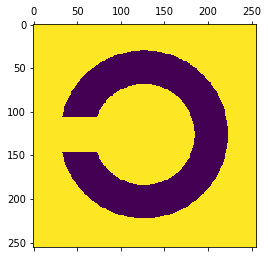

<Figure size 432x288 with 0 Axes>

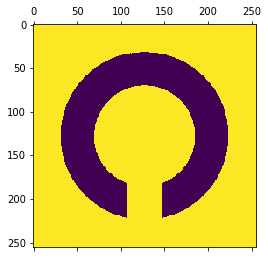

<Figure size 432x288 with 0 Axes>

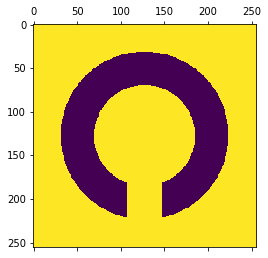

In [52]:
for i in range(0, 4*repeats):
    plt.figure()
    plt.matshow(test_set[i].reshape(256, 256))

In [ ]:
#end goal
result_matrix = np.empty((9,9,9))
for i in range(0,9):
    for j in range(0,9):
        for k in range(0,9):
            subs = image_set(B[i*(9*9) + j*9 + k], noise=noises[i], compress=compressions[j], scaling=scalings[k], dim=256, itr=iterations)
            result_matrix[i][j][k] = cross_validate(subs)#sum(results) / size